In [1]:
import os
import re
import json
import cv2
import numpy as np
from skimage import io, exposure, feature, color, transform, filters
from sklearn import svm
from sklearn.feature_extraction.image import extract_patches_2d
import matplotlib.pyplot as plt

from utils import *
from bbox3D_to_bbox2D import to_bbox2D

## Helper functions

In [2]:
def pick_valid_name(start_string, directory, extension=".png"):
    if not os.path.isdir(directory):
        raise OSError("You didn't pass a valid directory")
    fname = start_string + extension
    i = 1
    while True:
        # filename already exists
        if os.path.isfile(os.path.join(directory, fname)):
            i += 1
            fname = start_string + str(i) + extension
        else:
            return fname

## Directories and parameters

In [3]:
# dirs
root_dir = "/media/david/TOSHIBA EXT/DavidINLOC/tfmdbs/custom_db_objects"
train_dir = os.path.join(root_dir, "train")
val_dir = os.path.join(root_dir, "val")

# params
window_shape = (200, 100)

## Train

In [4]:
X = []
y = []

print(f"Training for classes: {os.listdir(train_dir)}")
for class_name in os.listdir(train_dir):
    print(f"Collecting images for class: {class_name}...")
    class_dir = os.path.join(train_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        
        # read image
        im = io.imread(image_path)

        # artificially augment image by choosing wide patches
        patch_size = (int(im.shape[0]*0.85), int(im.shape[1]*0.85))
        for augmented_patch in extract_patches_2d(im, patch_size, max_patches=20, random_state=2):
            # blur, sharpen, and compute HoG
            (H, hog_image) = compute_hog(augmented_patch, window_shape)

        X.append(H)
        y.append(class_name)

model = svm.LinearSVC()
model.fit(X, y)
print("Done!")

Training for classes: ['cocacola', 'none', 'pepsi']
Done!


## Predict

In [8]:
X = []
y = []
image_paths = []
for class_name in os.listdir(val_dir):
    class_dir = os.path.join(val_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        
        # read image
        im = io.imread(image_path)
        
        # blur, sharpen, and compute HoG
        (H, hog_image) = compute_hog(im, window_shape)

        X.append(H)
        y.append(class_name)
        image_paths.append(image_path)

# predict with the trained SVM
pred = model.predict(X)

# prediction vs ground truth
for i in range(len(X)):
    print(f"Pred: {pred[i]}, GT: {y[i]}. {pred[i]==y[i]}!")
    if pred[i] != y[i]:
        # move the failed detection to training
        new_path = re.sub("val", "train", image_paths[i])
        os.rename(image_paths[i], new_path)

['none' 'none' 'none' 'none' 'none' 'pepsi' 'pepsi' 'pepsi' 'pepsi'
 'pepsi']
Pred: none, GT: none. True!
Pred: none, GT: none. True!
Pred: none, GT: none. True!
Pred: none, GT: none. True!
Pred: none, GT: none. True!
Pred: pepsi, GT: pepsi. True!
Pred: pepsi, GT: pepsi. True!
Pred: pepsi, GT: pepsi. True!
Pred: pepsi, GT: pepsi. True!
Pred: pepsi, GT: pepsi. True!


## Inference on unlabeled images

In [9]:
inference_image_path = "../img/pepsi_model.jpeg"
img = io.imread(inference_image_path)

for scale_row, scale_col, image in image_pyramid(img, window_shape):
    for row, col, patch in sliding_window(image, window_shape):
        # predict
        (H, hog_image) = compute_hog(patch, window_shape)
        predicted_class = model.predict(H.reshape(1, -1))[0]

        if predicted_class != "none":
            plt.imshow(patch)
            plt.title(predicted_class)
            plt.show()
        

## Inference with sliding window and an image pyramid + Negative hard mining

In [6]:
# cocacola_and_pepsi.jpeg
# pepsi_alone.jpg
# cocacola_4inrow.jpg
inference_image_path = "../img/cocacola_and_pepsi.jpeg"
img = io.imread(inference_image_path)
labels_data = read_image_labels(inference_image_path)
bboxes_list = labels2bboxes(labels_data)

predictions = {}
tp_bboxes = [] # true positive (tp) bounding boxes
for scale_row, scale_col, image in image_pyramid(img, window_shape):
    for row, col, patch in sliding_window(image, window_shape):
        # predict
        (H, hog_image) = compute_hog(patch, window_shape)
        predicted_class = model.predict(H.reshape(1, -1))[0]
        # store predictions
        if predicted_class in predictions:
            predictions[predicted_class] += 1
        else:
            predictions[predicted_class] = 1
        
        # check if the prediction is true by looking at the label
        top_row = row // scale_row
        top_col = col // scale_col
        height = window_shape[0] // scale_row
        width = window_shape[1] // scale_col
        bbox_from_patch = (predicted_class, [top_col, top_row, width, height])
        
    
        # compute IoU of the current patch with the bboxes in the labels file
        iou = max([
            intersection_over_union(bbox, bbox_from_patch)
            for bbox in bboxes_list
        ])
        # negative hard mining
        if predicted_class != "none" and iou < 0.2:
            print(iou)
            show_bboxes(inference_image_path, bboxes_list + [bbox_from_patch])
            none_train_dir = os.path.join(train_dir, "none")
            fname = pick_valid_name("none", none_train_dir)
            # io.imsave(os.path.join(none_train_dir, fname), patch)
        # display detections with relevant iou
        elif predicted_class != "none" and iou > 0.5:
            print(iou)
            show_bboxes(inference_image_path, bboxes_list + [bbox_from_patch])
            tp_bboxes.append(bbox_from_patch)
        
print(predictions)

No labels file for ../img/cocacola_and_pepsi.jpeg!


TypeError: 'NoneType' object is not subscriptable

### testing below

In [ ]:
# read image
im = io.imread("../img/pepsi_quenova2.png")
im = filters.gaussian(im)

(H, hog_image) = compute_hog(im, window_shape)

pred = model.predict(H.reshape(1, -1))

print(pred)
plt.imshow(hog_image)
plt.show()
plt.imshow(im)
plt.show()

In [ ]:
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction.image import extract_patches_2d
# Use the array data from the first image in this dataset:
one_image = load_sample_image("china.jpg")
print('Image shape: {}'.format(one_image.shape))

patches = extract_patches_2d(one_image, (300, 400), max_patches=20, random_state=2)
print('Patches shape: {}'.format(patches.shape))


In [ ]:
plt.imshow(patches[5])
plt.show()

In [ ]:
# cocacola_and_pepsi.jpeg

image_path = "../img/cocacola_and_pepsi.jpeg"
labels_data = read_image_labels(image_path)
bboxes = labels2bboxes(labels_data)
show_bboxes(image_path, bboxes)
print(intersection_over_union(bboxes[0], bboxes[1]))

In [ ]:
# read image and blur
img = io.imread("../img/cocacola_and_pepsi.jpeg")
blurred_img = filters.gaussian(img, sigma=3, multichannel=True)
# compute the HoG of the original image and the blurred one
(H, hog_img) = feature.hog(color.rgb2gray(img), orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", feature_vector=True, visualize=True)
hog_img = exposure.rescale_intensity(hog_img, out_range=(0, 255)).astype(np.uint8)
(H, hog_blurred_img) = feature.hog(color.rgb2gray(blurred_img), orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", feature_vector=True, visualize=True)
hog_blurred_img = exposure.rescale_intensity(hog_blurred_img, out_range=(0, 255)).astype(np.uint8)

# display results
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 9))
ax[0,0].imshow(img)
ax[0,0].set_title("Original image")
ax[0,1].imshow(blurred_img)
ax[0,1].set_title("Blurred image")
ax[1,0].imshow(hog_img)
ax[1,0].set_title("HoG image")
ax[1,1].imshow(hog_blurred_img)
ax[1,1].set_title("HoG blurred image")
plt.show()

In [ ]:
# read image and blur
img = io.imread("../img/cocacola_and_pepsi.jpeg")
blurred_img = filters.gaussian(img, sigma=3, multichannel=True)

result_1 = filters.unsharp_mask(img, radius=1, amount=1)
result_2 = filters.unsharp_mask(img, radius=5, amount=2)
result_3 = filters.unsharp_mask(img, radius=20, amount=1)

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(result_1, cmap=plt.cm.gray)
ax[1].set_title('Enhanced image, radius=1, amount=1.0')
ax[2].imshow(result_2, cmap=plt.cm.gray)
ax[2].set_title('Enhanced image, radius=5, amount=2.0')
ax[3].imshow(result_3, cmap=plt.cm.gray)
ax[3].set_title('Enhanced image, radius=20, amount=1.0')

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()


In [ ]:
test_image = color.rgb2gray(img)
test_image = filters.gaussian(test_image, sigma=2, multichannel=True)

plt.imshow(test_image)
plt.show()

(H, hog_img) = feature.hog(test_image, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", feature_vector=True, visualize=True)
hog_img = exposure.rescale_intensity(hog_img, out_range=(0, 255)).astype(np.uint8)
plt.imshow(hog_img)
plt.show()

## Predict after cropping from PCL-defined bounding boxes

In [15]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [4]:
# open labels dict for that image/PointCloud
pcd_dir = "../pcd/pointclouds_from_420726_09052021"
filename = "0"
labels_path = os.path.join(pcd_dir, filename) + ".json"
with open(labels_path, "r") as f:
    pc_label = json.load(f)
# read the camera intrinsic parameters
camintrinsics_fname = "camera_intrinsics.json"
camintrinsics_path = os.path.join(pcd_dir, camintrinsics_fname)
with open(camintrinsics_path, "r") as f:
    intrinsics = json.load(f)


# image in which to make inference
img_path = os.path.join(pcd_dir, filename + ".png")
img = io.imread(img_path)

hog_crops = []; crops = []; i = 0
for cluster in pc_label["annotation"]:
    try:
        # point to relative coordinates
        x, y, width, height = to_bbox2D(cluster["bbox"], img.shape[:2], intrinsics)
        crop = img[y:y + height, x:x + width, :]
        # compute HoG on the crop
        (H, hog_image) = compute_hog(crop, window_shape)
        crops.append(crop)
        hog_crops.append(hog_image)
        pred = model.predict(H.reshape(1, -1))
        plt.imshow(crop)
        plt.title(pred)
        plt.show()
        i += 1
    except Exception as e:
        print(f"Error! x:{x}, y:{y}, width:{width}, height:{height}")
        print("\t", e)


Error! x:486, y:123, width:96, height:159
	 name 'model' is not defined
Error! x:787, y:295, width:-37, height:94
	 ('Cannot warp empty image with dimensions', (94, 0))
Error! x:278, y:235, width:103, height:148
	 name 'model' is not defined
Error! x:276, y:95, width:40, height:134
	 name 'model' is not defined
Error! x:137, y:239, width:169, height:130
	 name 'model' is not defined
Error! x:98, y:432, width:628, height:46
	 name 'model' is not defined
Error! x:562, y:140, width:34, height:136
	 name 'model' is not defined
Error! x:413, y:293, width:47, height:77
	 name 'model' is not defined
Error! x:291, y:81, width:92, height:99
	 name 'model' is not defined
Error! x:211, y:462, width:112, height:9
	 name 'model' is not defined
Error! x:583, y:315, width:38, height:66
	 name 'model' is not defined
Error! x:767, y:452, width:42, height:25
	 name 'model' is not defined
Error! x:671, y:316, width:30, height:66
	 name 'model' is not defined
Error! x:499, y:282, width:39, height:91
	 nam

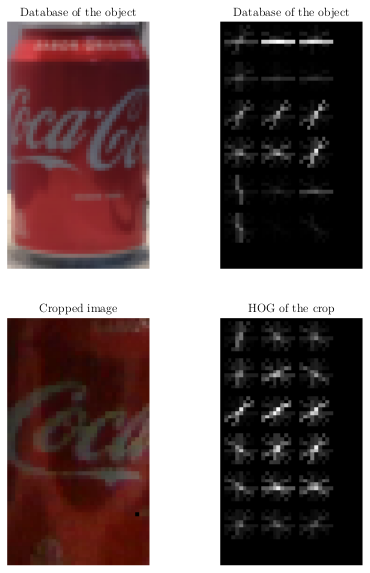

In [40]:
# for the report
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 10))
ax = axes.ravel()

current_crop = crops[9]

img = io.imread("../img/cocacola_model.jpeg")
img = transform.resize(img, current_crop.shape[:2])

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Database of the object')
ax[0].set_axis_off()

(H, hog_image) = feature.hog(img, orientations=9, pixels_per_cell=(10, 10),
        cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", 
        feature_vector=True, visualize=True)
ax[1].imshow(hog_image, cmap=plt.cm.gray)
ax[1].set_title('Database of the object')
ax[1].set_axis_off()

ax[2].imshow(current_crop, cmap=plt.cm.gray)
ax[2].set_title('Cropped image')
ax[2].set_axis_off()

(H, hog_image) = feature.hog(current_crop, orientations=9, pixels_per_cell=(10, 10),
        cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", 
        feature_vector=True, visualize=True)
ax[3].imshow(hog_image, cmap=plt.cm.gray)
ax[3].set_title('HOG of the crop')
ax[3].set_axis_off()

plt.savefig("../../report/images/hog_cocacola_crop.pgf")